In [1]:
import os
import pickle
import numpy as np
import scipy.interpolate as spi
import matplotlib.pyplot as plt
%matplotlib inline

import flayer
import particle_evolution
import feo_thermodynamics as feot
import multiprocessing
import bulk_case_runner

# We have some annoying warnings - I think from llvm bug - fix then remove this
#import warnings
#warnings.filterwarnings("ignore")

## Cases corresponding to the five highlighted points on Figure 5

The difference is that the temperature, pressure and gravity change through the
200 km thick layer, and the composition is solved self-consistently with the total
solid volume (from all falling particles). 

The setup ends up giving us a much hotter layer (lower $\Delta \mu_{Fe}$) as we need
to intersect the liquidus at 200 km. A better comparison is probably T = 5700 K for
Figure 5 (not 5000 K) or reduce the amount of O, or make the layer thicker.

Temperature at CMB is 4225.944695087244 K
Temberature at top of F-layer is 5676.644650924955 K
Temberature at ICB is 5744.191075723928 K


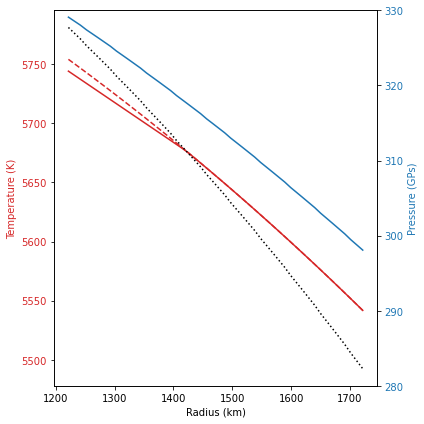

Wetting angle: 7.0
R = 1221500.0 I =  1.1675001794615251e-10 r0 =  3.009661759744961e-08 gc =  1.70329439482786e-19
R = 1222505.025125628 I =  1.147446648962602e-10 r0 =  3.0216875909321595e-08 gc =  1.716933438642464e-19
R = 1223510.0502512562 I =  1.1274548940133503e-10 r0 =  3.0338385591144595e-08 gc =  1.7307696473498283e-19
R = 1224515.0753768843 I =  1.1075283407028042e-10 r0 =  3.046116530998325e-08 gc =  1.7448068749829024e-19
R = 1225520.1005025127 I =  1.0876704622763789e-10 r0 =  3.0585234119138824e-08 gc =  1.7590490725018944e-19
R = 1226525.1256281408 I =  1.0678847834885352e-10 r0 =  3.0710611435837946e-08 gc =  1.773500287026136e-19
R = 1227530.1507537689 I =  1.0481748712981307e-10 r0 =  3.0837317104947526e-08 gc =  1.7881646710209895e-19
R = 1228535.175879397 I =  1.0285443404700653e-10 r0 =  3.0965371368520274e-08 gc =  1.8030464807435948e-19
R = 1229540.201005025 I =  1.0089968527853136e-10 r0 =  3.109479487431235e-08 gc =  1.8181500792043838e-19
R = 1230545.22613065

R = 1308937.1859296483 I =  3.467335820621571e-12 r0 =  4.87512081417546e-08 gc =  4.469151759508222e-19
R = 1309942.2110552764 I =  3.1705338213358557e-12 r0 =  4.9133329352530854e-08 gc =  4.539486449090377e-19
R = 1310947.2361809046 I =  2.8924345561273216e-12 r0 =  4.952226283685971e-08 gc =  4.611638948333843e-19
R = 1311952.2613065327 I =  2.632412489750527e-12 r0 =  4.9918190302018854e-08 gc =  4.685673263069575e-19
R = 1312957.2864321608 I =  2.389827850827422e-12 r0 =  5.0321299753128715e-08 gc =  4.761656215715314e-19
R = 1313962.3115577889 I =  2.1640282080441257e-12 r0 =  5.073178607356686e-08 gc =  4.839657653041441e-19
R = 1314967.3366834172 I =  1.95435034772865e-12 r0 =  5.114985138319785e-08 gc =  4.919750620598349e-19
R = 1315972.3618090453 I =  1.760122391531955e-12 r0 =  5.157570508694339e-08 gc =  5.002011484865075e-19
R = 1316977.3869346734 I =  1.5806656888136544e-12 r0 =  5.2009564533428713e-08 gc =  5.086520179891375e-19
R = 1317982.4120603015 I =  1.4152970652

R = 1397379.3969849246 I =  3.776212650566946e-59 r0 =  2.1794343684878295e-07 gc =  8.931860410556417e-18
R = 1398384.4221105527 I =  1.872944118346083e-63 r0 =  2.272295150120945e-07 gc =  9.709208330829596e-18
R = 1399389.447236181 I =  2.3526769120387227e-68 r0 =  2.3736010179147817e-07 gc =  1.0594239237751711e-17
R = 1400394.472361809 I =  5.731506710604518e-74 r0 =  2.4845583994312257e-07 gc =  1.1607875871242997e-17
R = 1401399.4974874372 I =  1.9369475667204517e-80 r0 =  2.6066150142575116e-07 gc =  1.2776388869434807e-17
R = 1402404.5226130653 I =  5.934367361917383e-88 r0 =  2.741523370892585e-07 gc =  1.4133126357223e-17
R = 1403409.5477386934 I =  9.54314767492597e-97 r0 =  2.8914254102750677e-07 gc =  1.5720933241103994e-17
R = 1404414.5728643215 I =  3.9539868491609846e-107 r0 =  3.0589670714749784e-07 gc =  1.7595594335074317e-17
R = 1405419.5979899499 I =  1.6482495785485462e-119 r0 =  3.2474557670072864e-07 gc =  1.9830826982048103e-17
R = 1406424.623115578 I =  1.954

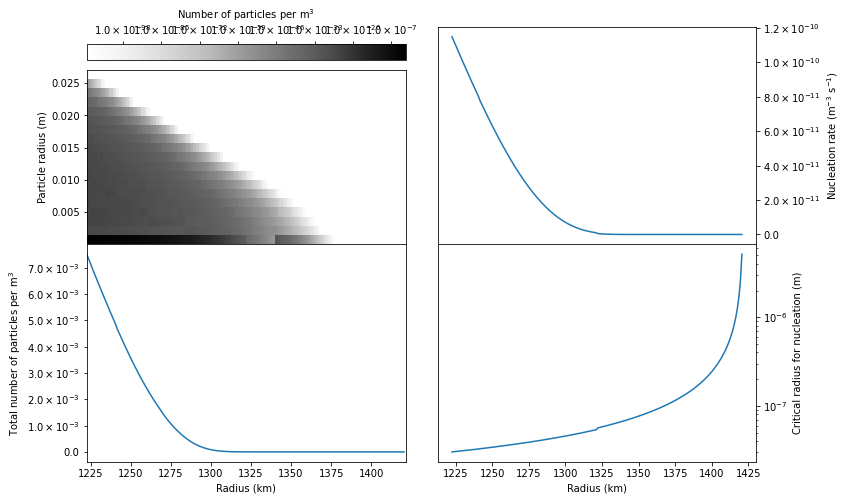

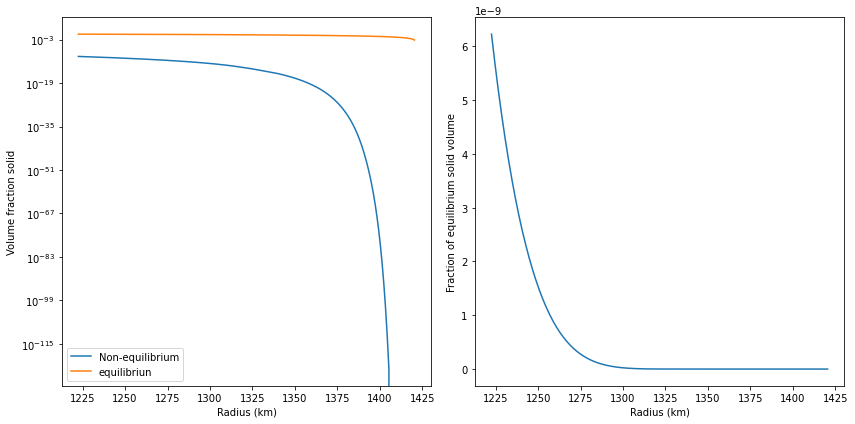


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



Wetting angle: 7.0
R = 1221500.0 I =  1.1675001794615251e-10 r0 =  3.009661759744961e-08 gc =  1.70329439482786e-19
R = 1222505.025125628 I =  1.147446648962602e-10 r0 =  3.0216875909321595e-08 gc =  1.716933438642464e-19
R = 1223510.0502512562 I =  1.1274548940133503e-10 r0 =  3.0338385591144595e-08 gc =  1.7307696473498283e-19
R = 1224515.0753768843 I =  1.1075283407028042e-10 r0 =  3.046116530998325e-08 gc =  1.7448068749829024e-19
R = 1225520.1005025127 I =  1.0876704622763789e-10 r0 =  3.0585234119138824e-08 gc =  1.7590490725018944e-19
R = 1226525.1256281408 I =  1.0678847834885352e-10 r0 =  3.0710611435837946e-08 gc =  1.773500287026136e-19
R = 1227530.1507537689 I =  1.0481748712981307e-10 r0 =  3.0837317104947526e-08 gc =  1.7881646710209895e-19
R = 1228535.175879397 I =  1.0285443404700653e-10 r0 =  3.0965371368520274e-08 gc =  1.8030464807435948e-19
R = 1229540.201005025 I =  1.0089968527853136e-10 r0 = 

R = 1306927.135678392 I =  4.119467760129608e-12 r0 =  4.800670731528545e-08 gc =  4.333693333667514e-19
R = 1307932.16080402 I =  3.783449885047613e-12 r0 =  4.837572392469464e-08 gc =  4.400573620666294e-19
R = 1308937.1859296483 I =  3.467335820621571e-12 r0 =  4.87512081417546e-08 gc =  4.469151759508222e-19
R = 1309942.2110552764 I =  3.1705338213358557e-12 r0 =  4.9133329352530854e-08 gc =  4.539486449090377e-19
R = 1310947.2361809046 I =  2.8924345561273216e-12 r0 =  4.952226283685971e-08 gc =  4.611638948333843e-19
R = 1311952.2613065327 I =  2.632412489750527e-12 r0 =  4.9918190302018854e-08 gc =  4.685673263069575e-19
R = 1312957.2864321608 I =  2.389827850827422e-12 r0 =  5.0321299753128715e-08 gc =  4.761656215715314e-19
R = 1313962.3115577889 I =  2.1640282080441257e-12 r0 =  5.073178607356686e-08 gc =  4.839657653041441e-19
R = 1314967.3366834172 I =  1.95435034772865e-12 r0 =  5.114985138319785e-08 gc =  4.919750620598349e-19
R = 1315972.3618090453 I =  1.760122391531955

R = 1394364.3216080402 I =  5.76048610722162e-49 r0 =  1.9421391498278623e-07 gc =  7.0927560450048e-18
R = 1395369.3467336684 I =  5.6520144897932784e-52 r0 =  2.0151503450052136e-07 gc =  7.636058436560849e-18
R = 1396374.3718592965 I =  2.38994679457677e-55 r0 =  2.094005261776843e-07 gc =  8.245364783499022e-18
R = 1397379.3969849246 I =  3.776212650566946e-59 r0 =  2.1794343684878295e-07 gc =  8.931860410556417e-18
R = 1398384.4221105527 I =  1.872944118346083e-63 r0 =  2.272295150120945e-07 gc =  9.709208330829596e-18
R = 1399389.447236181 I =  2.3526769120387227e-68 r0 =  2.3736010179147817e-07 gc =  1.0594239237751711e-17
R = 1400394.472361809 I =  5.731506710604518e-74 r0 =  2.4845583994312257e-07 gc =  1.1607875871242997e-17
R = 1401399.4974874372 I =  1.9369475667204517e-80 r0 =  2.6066150142575116e-07 gc =  1.2776388869434807e-17
R = 1402404.5226130653 I =  5.934367361917383e-88 r0 =  2.741523370892585e-07 gc =  1.4133126357223e-17
R = 1403409.5477386934 I =  9.543147674925

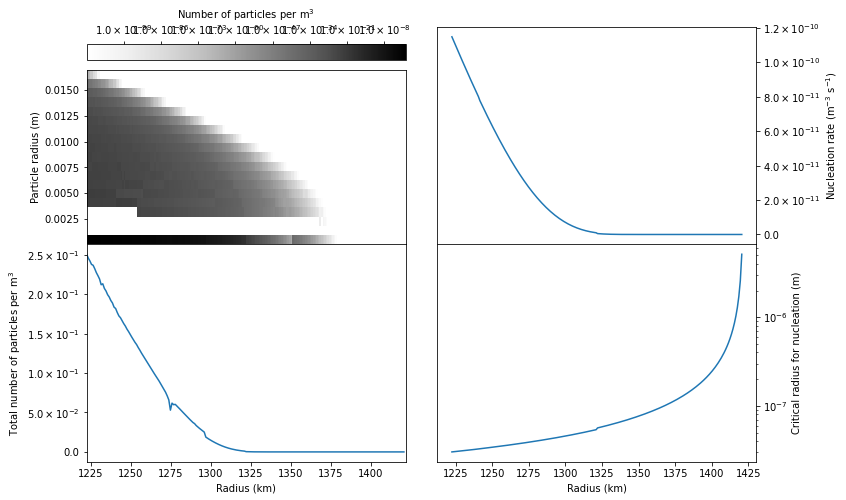

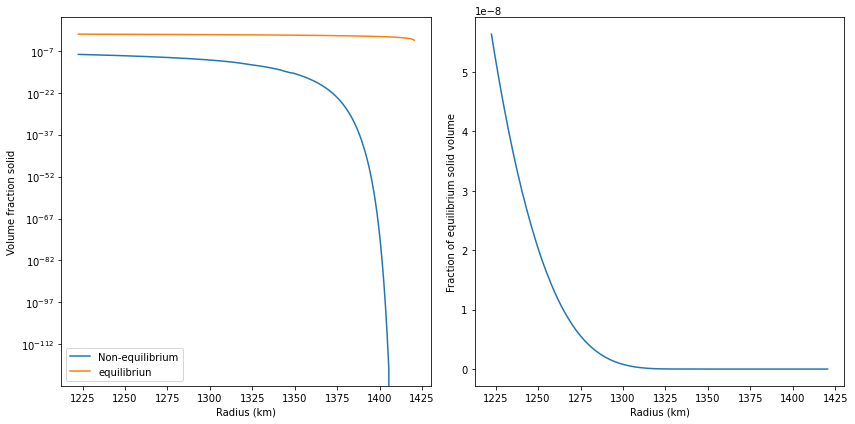


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



Wetting angle: 7.0
R = 1221500.0 I =  1.1675001794615251e-10 r0 =  3.009661759744961e-08 gc =  1.70329439482786e-19
R = 1222505.025125628 I =  1.147446648962602e-10 r0 =  3.0216875909321595e-08 gc =  1.716933438642464e-19
R = 1223510.0502512562 I =  1.1274548940133503e-10 r0 =  3.0338385591144595e-08 gc =  1.7307696473498283e-19
R = 1224515.0753768843 I =  1.1075283407028042e-10 r0 =  3.046116530998325e-08 gc =  1.7448068749829024e-19
R = 1225520.1005025127 I =  1.0876704622763789e-10 r0 =  3.0585234119138824e-08 gc =  1.7590490725018944e-19
R = 1226525.1256281408 I =  1.0678847834885352e-10 r0 =  3.0710611435837946e-08 gc =  1.773500287026136e-19
R = 1227530.1507537689 I =  1.0481748712981307e-10 r0 =  3.0837317104947526e-08 gc =  1.7881646710209895e-19
R = 1228535.175879397 I =  1.0285443404700653e-10 r0 =  3.0965371368520274e-08 gc =  1.8030464807435948e-19
R = 1229540.201005025 I =  1.0089968527853136e-10 r0 = 

R = 1307932.16080402 I =  3.783449885047613e-12 r0 =  4.837572392469464e-08 gc =  4.400573620666294e-19
R = 1308937.1859296483 I =  3.467335820621571e-12 r0 =  4.87512081417546e-08 gc =  4.469151759508222e-19
R = 1309942.2110552764 I =  3.1705338213358557e-12 r0 =  4.9133329352530854e-08 gc =  4.539486449090377e-19
R = 1310947.2361809046 I =  2.8924345561273216e-12 r0 =  4.952226283685971e-08 gc =  4.611638948333843e-19
R = 1311952.2613065327 I =  2.632412489750527e-12 r0 =  4.9918190302018854e-08 gc =  4.685673263069575e-19
R = 1312957.2864321608 I =  2.389827850827422e-12 r0 =  5.0321299753128715e-08 gc =  4.761656215715314e-19
R = 1313962.3115577889 I =  2.1640282080441257e-12 r0 =  5.073178607356686e-08 gc =  4.839657653041441e-19
R = 1314967.3366834172 I =  1.95435034772865e-12 r0 =  5.114985138319785e-08 gc =  4.919750620598349e-19
R = 1315972.3618090453 I =  1.760122391531955e-12 r0 =  5.157570508694339e-08 gc =  5.002011484865075e-19
R = 1316977.3869346734 I =  1.58066568881365

R = 1394364.3216080402 I =  5.76048610722162e-49 r0 =  1.9421391498278623e-07 gc =  7.0927560450048e-18
R = 1395369.3467336684 I =  5.6520144897932784e-52 r0 =  2.0151503450052136e-07 gc =  7.636058436560849e-18
R = 1396374.3718592965 I =  2.38994679457677e-55 r0 =  2.094005261776843e-07 gc =  8.245364783499022e-18
R = 1397379.3969849246 I =  3.776212650566946e-59 r0 =  2.1794343684878295e-07 gc =  8.931860410556417e-18
R = 1398384.4221105527 I =  1.872944118346083e-63 r0 =  2.272295150120945e-07 gc =  9.709208330829596e-18
R = 1399389.447236181 I =  2.3526769120387227e-68 r0 =  2.3736010179147817e-07 gc =  1.0594239237751711e-17
R = 1400394.472361809 I =  5.731506710604518e-74 r0 =  2.4845583994312257e-07 gc =  1.1607875871242997e-17
R = 1401399.4974874372 I =  1.9369475667204517e-80 r0 =  2.6066150142575116e-07 gc =  1.2776388869434807e-17
R = 1402404.5226130653 I =  5.934367361917383e-88 r0 =  2.741523370892585e-07 gc =  1.4133126357223e-17
R = 1403409.5477386934 I =  9.543147674925

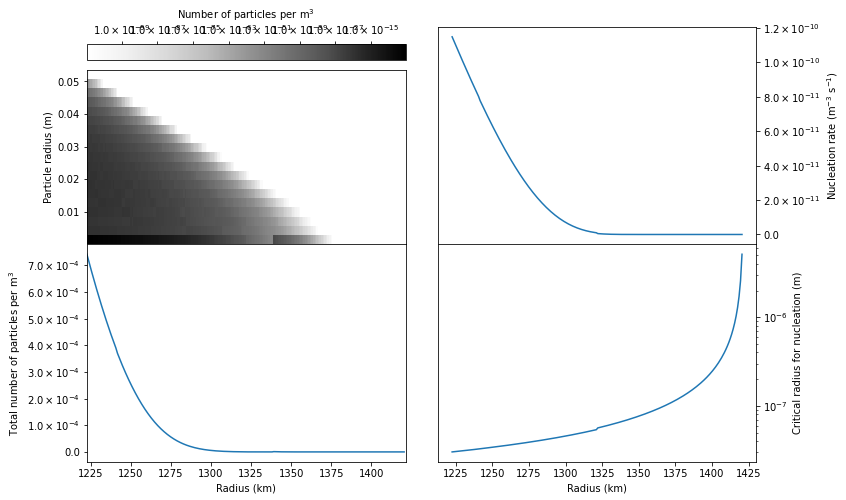

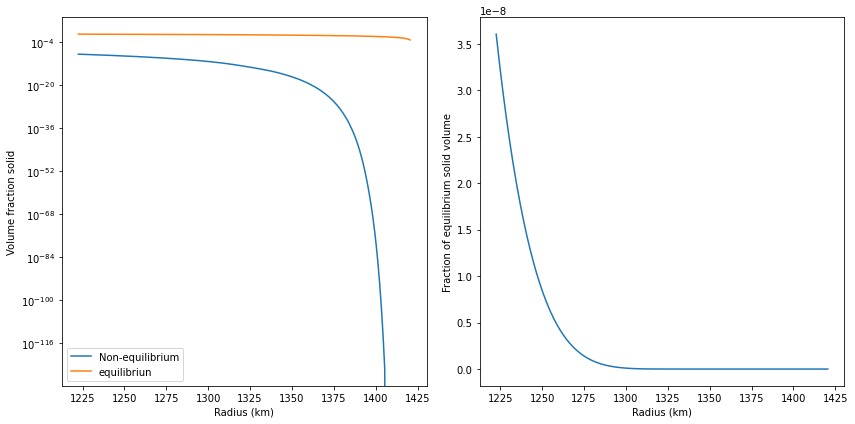


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



Wetting angle: 7.0
R = 1221500.0 I =  1.1675001794615251e-10 r0 =  3.009661759744961e-08 gc =  1.70329439482786e-19
R = 1222505.025125628 I =  1.147446648962602e-10 r0 =  3.0216875909321595e-08 gc =  1.716933438642464e-19
R = 1223510.0502512562 I =  1.1274548940133503e-10 r0 =  3.0338385591144595e-08 gc =  1.7307696473498283e-19
R = 1224515.0753768843 I =  1.1075283407028042e-10 r0 =  3.046116530998325e-08 gc =  1.7448068749829024e-19
R = 1225520.1005025127 I =  1.0876704622763789e-10 r0 =  3.0585234119138824e-08 gc =  1.7590490725018944e-19
R = 1226525.1256281408 I =  1.0678847834885352e-10 r0 =  3.0710611435837946e-08 gc =  1.773500287026136e-19
R = 1227530.1507537689 I =  1.0481748712981307e-10 r0 =  3.0837317104947526e-08 gc =  1.7881646710209895e-19
R = 1228535.175879397 I =  1.0285443404700653e-10 r0 =  3.0965371368520274e-08 gc =  1.8030464807435948e-19
R = 1229540.201005025 I =  1.0089968527853136e-10 r0 = 

R = 1305922.1105527638 I =  4.47596204318401e-12 r0 =  4.764399469733765e-08 gc =  4.2684546540661423e-19
R = 1306927.135678392 I =  4.119467760129608e-12 r0 =  4.800670731528545e-08 gc =  4.333693333667514e-19
R = 1307932.16080402 I =  3.783449885047613e-12 r0 =  4.837572392469464e-08 gc =  4.400573620666294e-19
R = 1308937.1859296483 I =  3.467335820621571e-12 r0 =  4.87512081417546e-08 gc =  4.469151759508222e-19
R = 1309942.2110552764 I =  3.1705338213358557e-12 r0 =  4.9133329352530854e-08 gc =  4.539486449090377e-19
R = 1310947.2361809046 I =  2.8924345561273216e-12 r0 =  4.952226283685971e-08 gc =  4.611638948333843e-19
R = 1311952.2613065327 I =  2.632412489750527e-12 r0 =  4.9918190302018854e-08 gc =  4.685673263069575e-19
R = 1312957.2864321608 I =  2.389827850827422e-12 r0 =  5.0321299753128715e-08 gc =  4.761656215715314e-19
R = 1313962.3115577889 I =  2.1640282080441257e-12 r0 =  5.073178607356686e-08 gc =  4.839657653041441e-19
R = 1314967.3366834172 I =  1.95435034772865

R = 1393359.2964824121 I =  2.846234285343939e-46 r0 =  1.874345569309266e-07 gc =  6.6062296165666786e-18
R = 1394364.3216080402 I =  5.76048610722162e-49 r0 =  1.9421391498278623e-07 gc =  7.0927560450048e-18
R = 1395369.3467336684 I =  5.6520144897932784e-52 r0 =  2.0151503450052136e-07 gc =  7.636058436560849e-18
R = 1396374.3718592965 I =  2.38994679457677e-55 r0 =  2.094005261776843e-07 gc =  8.245364783499022e-18
R = 1397379.3969849246 I =  3.776212650566946e-59 r0 =  2.1794343684878295e-07 gc =  8.931860410556417e-18
R = 1398384.4221105527 I =  1.872944118346083e-63 r0 =  2.272295150120945e-07 gc =  9.709208330829596e-18
R = 1399389.447236181 I =  2.3526769120387227e-68 r0 =  2.3736010179147817e-07 gc =  1.0594239237751711e-17
R = 1400394.472361809 I =  5.731506710604518e-74 r0 =  2.4845583994312257e-07 gc =  1.1607875871242997e-17
R = 1401399.4974874372 I =  1.9369475667204517e-80 r0 =  2.6066150142575116e-07 gc =  1.2776388869434807e-17
R = 1402404.5226130653 I =  5.934367361

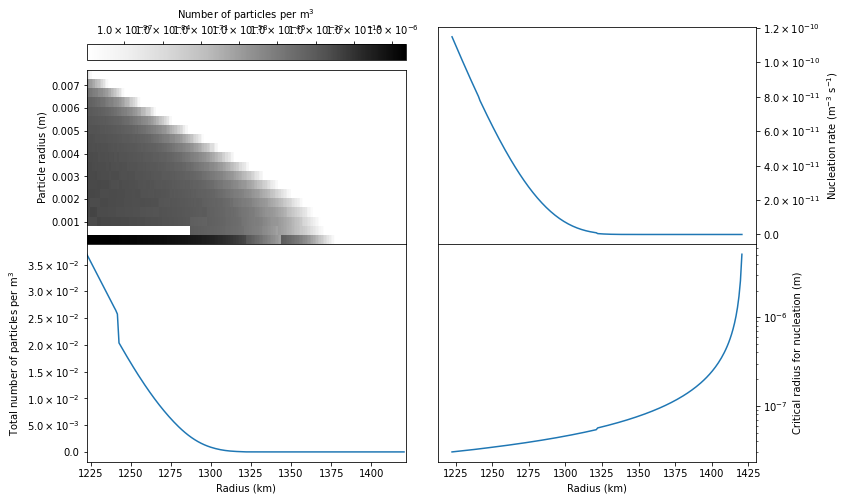

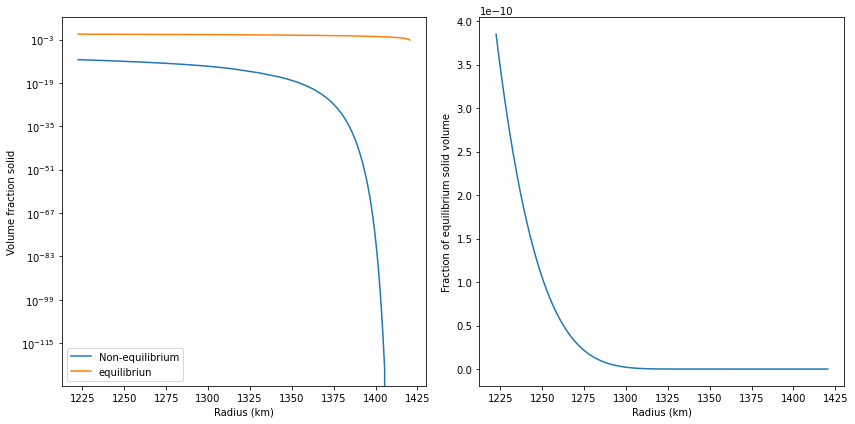


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



Wetting angle: 7.0
R = 1221500.0 I =  1.1675001794615251e-10 r0 =  3.009661759744961e-08 gc =  1.70329439482786e-19
R = 1222505.025125628 I =  1.147446648962602e-10 r0 =  3.0216875909321595e-08 gc =  1.716933438642464e-19
R = 1223510.0502512562 I =  1.1274548940133503e-10 r0 =  3.0338385591144595e-08 gc =  1.7307696473498283e-19
R = 1224515.0753768843 I =  1.1075283407028042e-10 r0 =  3.046116530998325e-08 gc =  1.7448068749829024e-19
R = 1225520.1005025127 I =  1.0876704622763789e-10 r0 =  3.0585234119138824e-08 gc =  1.7590490725018944e-19
R = 1226525.1256281408 I =  1.0678847834885352e-10 r0 =  3.0710611435837946e-08 gc =  1.773500287026136e-19
R = 1227530.1507537689 I =  1.0481748712981307e-10 r0 =  3.0837317104947526e-08 gc =  1.7881646710209895e-19
R = 1228535.175879397 I =  1.0285443404700653e-10 r0 =  3.0965371368520274e-08 gc =  1.8030464807435948e-19
R = 1229540.201005025 I =  1.0089968527853136e-10 r0 = 

R = 1307932.16080402 I =  3.783449885047613e-12 r0 =  4.837572392469464e-08 gc =  4.400573620666294e-19
R = 1308937.1859296483 I =  3.467335820621571e-12 r0 =  4.87512081417546e-08 gc =  4.469151759508222e-19
R = 1309942.2110552764 I =  3.1705338213358557e-12 r0 =  4.9133329352530854e-08 gc =  4.539486449090377e-19
R = 1310947.2361809046 I =  2.8924345561273216e-12 r0 =  4.952226283685971e-08 gc =  4.611638948333843e-19
R = 1311952.2613065327 I =  2.632412489750527e-12 r0 =  4.9918190302018854e-08 gc =  4.685673263069575e-19
R = 1312957.2864321608 I =  2.389827850827422e-12 r0 =  5.0321299753128715e-08 gc =  4.761656215715314e-19
R = 1313962.3115577889 I =  2.1640282080441257e-12 r0 =  5.073178607356686e-08 gc =  4.839657653041441e-19
R = 1314967.3366834172 I =  1.95435034772865e-12 r0 =  5.114985138319785e-08 gc =  4.919750620598349e-19
R = 1315972.3618090453 I =  1.760122391531955e-12 r0 =  5.157570508694339e-08 gc =  5.002011484865075e-19
R = 1316977.3869346734 I =  1.58066568881365

R = 1395369.3467336684 I =  5.6520144897932784e-52 r0 =  2.0151503450052136e-07 gc =  7.636058436560849e-18
R = 1396374.3718592965 I =  2.38994679457677e-55 r0 =  2.094005261776843e-07 gc =  8.245364783499022e-18
R = 1397379.3969849246 I =  3.776212650566946e-59 r0 =  2.1794343684878295e-07 gc =  8.931860410556417e-18
R = 1398384.4221105527 I =  1.872944118346083e-63 r0 =  2.272295150120945e-07 gc =  9.709208330829596e-18
R = 1399389.447236181 I =  2.3526769120387227e-68 r0 =  2.3736010179147817e-07 gc =  1.0594239237751711e-17
R = 1400394.472361809 I =  5.731506710604518e-74 r0 =  2.4845583994312257e-07 gc =  1.1607875871242997e-17
R = 1401399.4974874372 I =  1.9369475667204517e-80 r0 =  2.6066150142575116e-07 gc =  1.2776388869434807e-17
R = 1402404.5226130653 I =  5.934367361917383e-88 r0 =  2.741523370892585e-07 gc =  1.4133126357223e-17
R = 1403409.5477386934 I =  9.54314767492597e-97 r0 =  2.8914254102750677e-07 gc =  1.5720933241103994e-17
R = 1404414.5728643215 I =  3.953986849

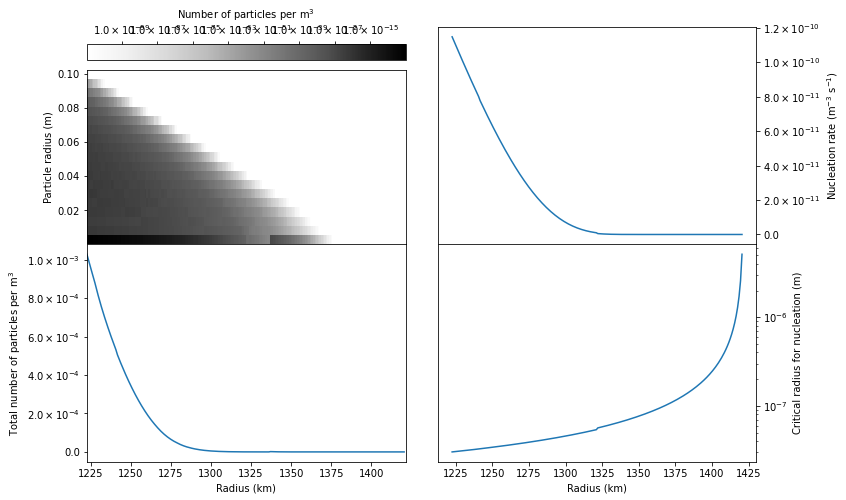

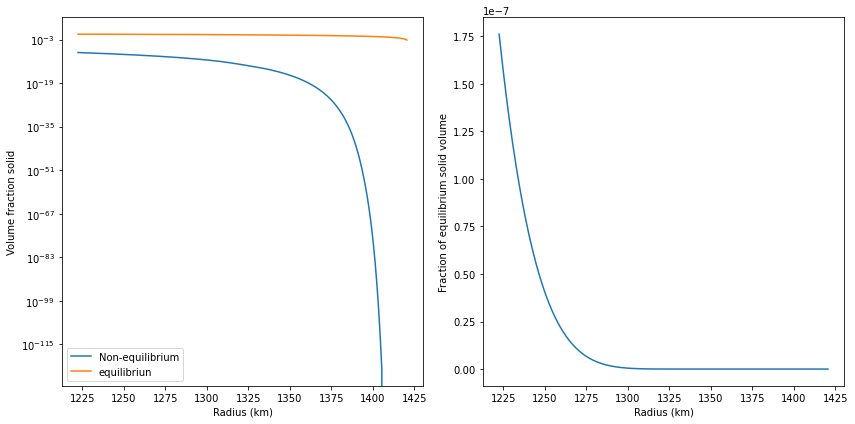


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++





In [2]:
parameters = {'f_layer_thickness': 200.0E3,
              'delta_t_icb': 10.0,
              'xfe_outer_core': 0.95,
              'xfe_icb': 0.95,
              'growth_prefactor': 150.0,
              'i0': 1.0E-9,
              'surf_energy': 1.08,
              'wetting_angle': 7.0,
              'hetrogeneous_radius': None,
              'number_of_analysis_points': 200,
              'r_icb': 1221.5E3, 
              'r_cmb': 3480.0E3,
              'gruneisen_parameter': 1.5}

bulk_case_runner.plot_case_setup(**parameters)

# A set of five pairs of parameters. Tuples of (diffusivity, viscosity)
cases_diff_visc = ((1.0E-9, 1.0E-6), (1.0E-9, 5.0E-4), (1.0E-9, 1.0E-7), (1.0E-10, 1.0E-6), (1.0E-8, 1.0E-6))
cases_key = ("yellow square", "red square", "orange square", "light blue square", "dark blue square")
# Output lists
max_vf_ratio = []
icb_flux = []
max_particle_size = []
max_excess_oxygen_mass = []

# Just do runs in serial
for i, input_params in enumerate(cases_diff_visc):
    
    parameters['chemical_diffusivity'] = input_params[0]
    parameters['kinematic_viscosity'] = input_params[1]
    
    filename = f"cases/five-cases/case_{i}.pickle"
    if os.path.exists(filename):
        # We have this model run on disk. Just read...
        data = bulk_case_runner.load_case_data(filename)    
    else:
        # Run this model case
        data = bulk_case_runner.run_flayer_case(parameters, filename)
    
    print(f"\nCorresponds to {cases_key[i]}")
    print(f"Chemical diffusivity: {data['chemical_diffusivity']:.3g}, kinematic viscosoity: {data['kinematic_viscosity']:.2e}")
    print(f"Inner core growth rate is {data['growth_rate']:.3g} km/Myr")
    print(f"Max vf_ratio is {np.nanmax(data['vf_ratio']):.3g}")
    max_extra_o = np.max(feot.mass_percent_o(data["opt_xl"]) -  feot.mass_percent_o(data["xfe_outer_core"]))
    print(f"Max extra O in liquid {max_extra_o:.2e} % O by mass")
    max_particle_radius = data["particle_radii"][data["particle_radii"] > 0.0].max()
    min_particle_radius = data["particle_radii"][data["particle_radii"] > 0.0].min()
    print(f"Particle radii between {max_particle_radius:.3g} and {min_particle_radius:.3g} m")

    max_vf_ratio.append(np.nanmax(data['vf_ratio']))
    icb_flux.append(data["growth_rate"])
    max_particle_size.append(max_particle_radius)
    max_excess_oxygen_mass.append(max_extra_o)

    bulk_case_runner.plot_case_csd_nuc(logscale=True, nonuc=False, **data)
    bulk_case_runner.plot_case_solid_frac(**data)
    print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n\n")